# TSLA Stock Price Prediction (2020-present)
### Using 5 different methods: KNN, Decision Trees, Random Forest Regression, ANN (PyTorch), and LSTM (PyTorch)


In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


## 1. Download TSLA Data

[*********************100%***********************]  1 of 1 completed


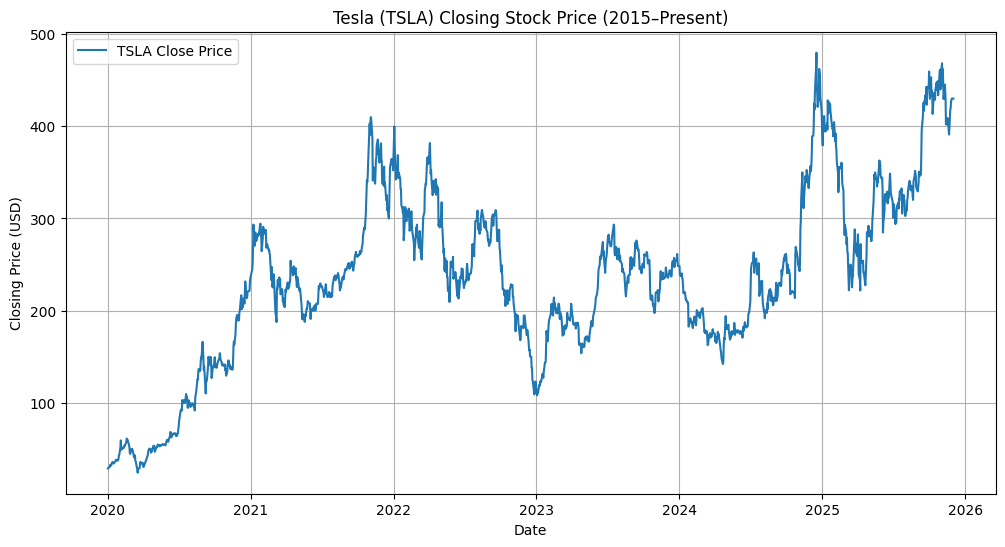

In [21]:
import yfinance as yf
import matplotlib.pyplot as plt

df = yf.download("TSLA", start="2020-01-01", auto_adjust=True)

# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="TSLA Close Price")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.title("Tesla (TSLA) Closing Stock Price (2015–Present)")
plt.legend()
plt.grid(True)
plt.show()



## 2. Feature Engineering

In [22]:
# --- Feature Engineering ---
df.columns = df.columns.get_level_values(0)

# 1. Daily returns
df['Return'] = df['Close'].pct_change()

# 2. Moving averages (technical indicators)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 3. Rolling volatility
df['Volatility'] = df['Close'].rolling(window=10).std()

# 4. Lag features (super important for ML)
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['Lag5'] = df['Close'].shift(5)
df['Lag10'] = df['Close'].shift(10)

# Drop rows created by rolling windows
df.dropna(inplace=True)

df.head()




Price,Close,High,Low,Open,Volume,Return,MA5,MA10,MA20,Volatility,Lag1,Lag2,Lag5,Lag10
Date,,,,,,,,,,,,,,
2020-01-30,42.720669,43.391998,41.200001,42.161331,435085500,0.102962,38.820533,37.496600,34.837566,2.434640,38.732666,37.793331,38.146667,34.566666
2020-01-31,43.371334,43.533333,42.167999,42.666668,235789500,0.015231,39.963866,38.410467,35.571933,2.765963,42.720669,38.732666,37.654667,34.232666
2020-02-03,52.000000,52.409332,44.901333,44.912666,705975000,0.198949,42.923600,40.207133,36.695233,4.738623,43.371334,42.720669,37.201332,34.033333
2020-02-04,59.137333,64.599335,55.591999,58.863998,914082000,0.137256,47.192400,42.472867,38.146966,7.417820,52.000000,43.371334,37.793331,36.480000
2020-02-05,48.980000,56.398666,46.940666,54.883999,726357000,-0.171758,49.241867,43.573800,39.032433,7.491987,59.137333,52.000000,38.732666,37.970669


## 3. Prepare Data (Supervised Learning)

In [23]:

features = ['Open','High','Low','Close','Volume',
            'Return','MA5','MA10','MA20',
            'Volatility','Lag1','Lag2','Lag5','Lag10']

X = df[features]

# 2. Create target: tomorrow's close price
df['Target'] = df['Close'].shift(-1)

# 3. Drop last row because Target is NaN
df = df.dropna()

# 4. Final X and y
X = df[features]
y = df['Target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


## 4. KNN Regression

In [37]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
pred_knn = knn.predict(X_test_scaled)

knn_error=mean_squared_error(y_test, pred_knn)
print(f"KNN MSE: {knn_error:.4f}")

knn_mae = mean_absolute_error(y_test, pred_knn)
print(f"KNN MAE: {knn_mae:.4f}")


KNN MSE: 1520.4441
KNN MAE: 29.3737


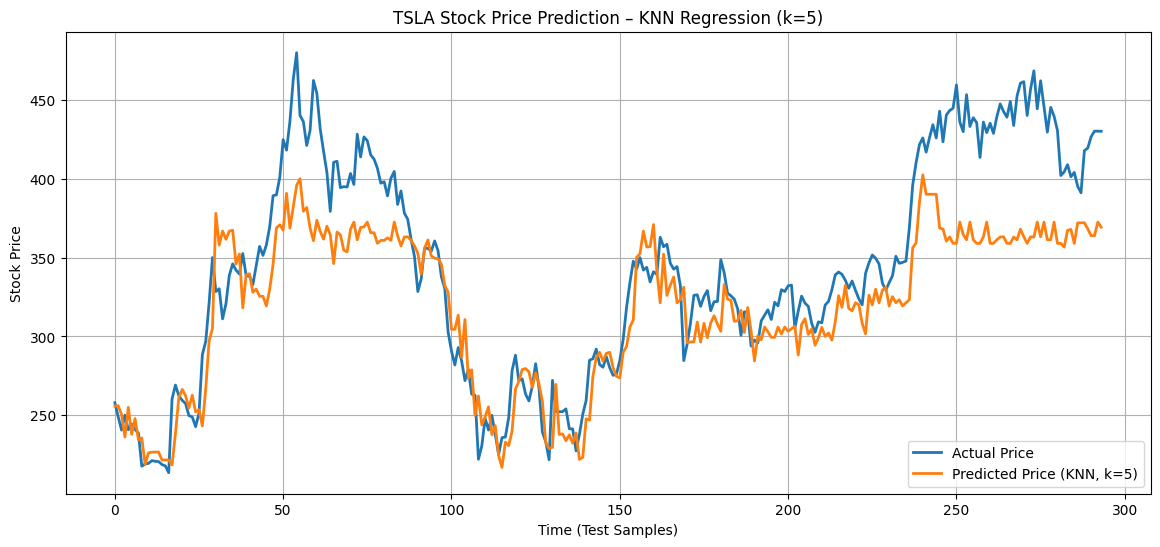

In [25]:
# --- Plot KNN Predictions ---
plt.figure(figsize=(14,6))

plt.plot(y_test.values, label="Actual Price", linewidth=2)
plt.plot(pred_knn, label="Predicted Price (KNN, k=5)", linewidth=2)

plt.title("TSLA Stock Price Prediction – KNN Regression (k=5)")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

## 5. Decision Tree

In [38]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)

DeTr_error=mean_squared_error(y_test, pred_tree)
print(f"Decision Tree MSE: {DeTr_error:.4f}")

DeTr_mae = mean_absolute_error(y_test, pred_tree)
print(f"Decision Tree MAE: {DeTr_mae:.4f}")

Decision Tree MSE: 1404.5598
Decision Tree MAE: 27.2048


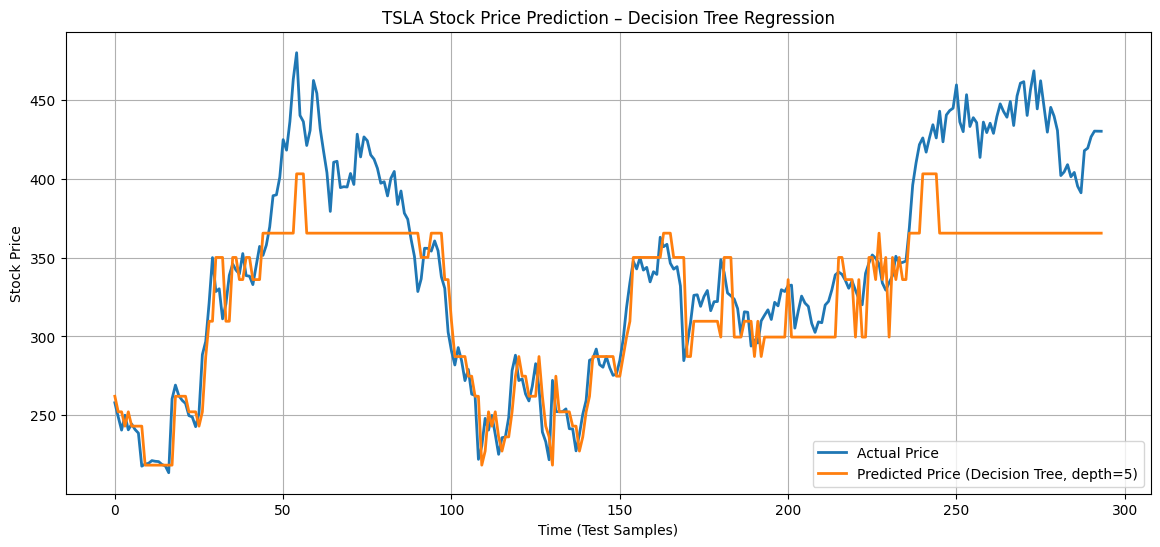

In [27]:
plt.figure(figsize=(14,6))

plt.plot(y_test.values, label="Actual Price", linewidth=2)
plt.plot(pred_tree, label="Predicted Price (Decision Tree, depth=5)", linewidth=2)

plt.title("TSLA Stock Price Prediction – Decision Tree Regression")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


## 6. Random Forest Regression


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train) 

pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf)
mae_rf = mean_absolute_error(y_test, pred_rf)
print(f"Random Forest – MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}")

Random Forest – MSE: 1170.7715, MAE: 24.7627


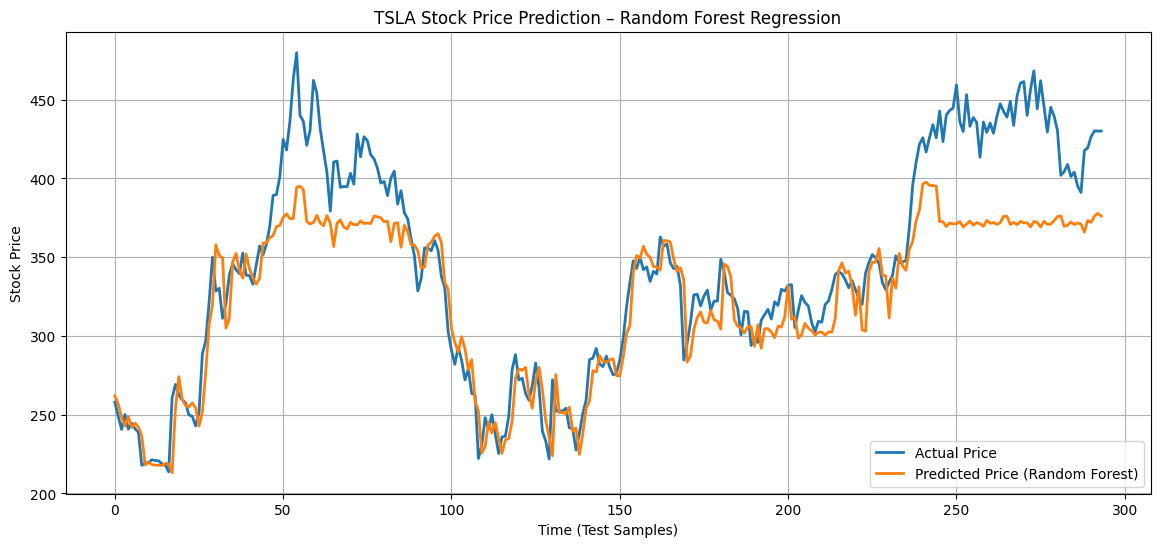

In [31]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual Price", linewidth=2)
plt.plot(pred_rf, label="Predicted Price (Random Forest)", linewidth=2)
plt.title("TSLA Stock Price Prediction – Random Forest Regression")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

## 7. ANN Regression (PyTorch MLP)


In [32]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP(input_dim=X_train_t.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

n_epochs = 100
for epoch in range(n_epochs):
    mlp.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = mlp(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train MSE: {avg_loss:.4f}")

# evaluate
mlp.eval()
with torch.no_grad():
    pred_mlp = mlp(X_test_t.to(device)).cpu().numpy().flatten()

mse_mlp = mean_squared_error(y_test, pred_mlp)
mae_mlp = mean_absolute_error(y_test, pred_mlp)
print(f"MLP – MSE: {mse_mlp:.4f}, MAE: {mae_mlp:.4f}")




Using device: cuda
Epoch 5/100, Train MSE: 27530.0582
Epoch 10/100, Train MSE: 10499.7163
Epoch 15/100, Train MSE: 4400.2130
Epoch 20/100, Train MSE: 1757.9616
Epoch 25/100, Train MSE: 955.6710
Epoch 30/100, Train MSE: 604.0046
Epoch 35/100, Train MSE: 392.0770
Epoch 40/100, Train MSE: 272.1676
Epoch 45/100, Train MSE: 195.3472
Epoch 50/100, Train MSE: 149.2382
Epoch 55/100, Train MSE: 119.4390
Epoch 60/100, Train MSE: 100.8360
Epoch 65/100, Train MSE: 89.0984
Epoch 70/100, Train MSE: 82.6117
Epoch 75/100, Train MSE: 80.5892
Epoch 80/100, Train MSE: 82.6855
Epoch 85/100, Train MSE: 73.8594
Epoch 90/100, Train MSE: 73.2341
Epoch 95/100, Train MSE: 72.9687
Epoch 100/100, Train MSE: 70.6279
MLP – MSE: 248.7090, MAE: 12.1681


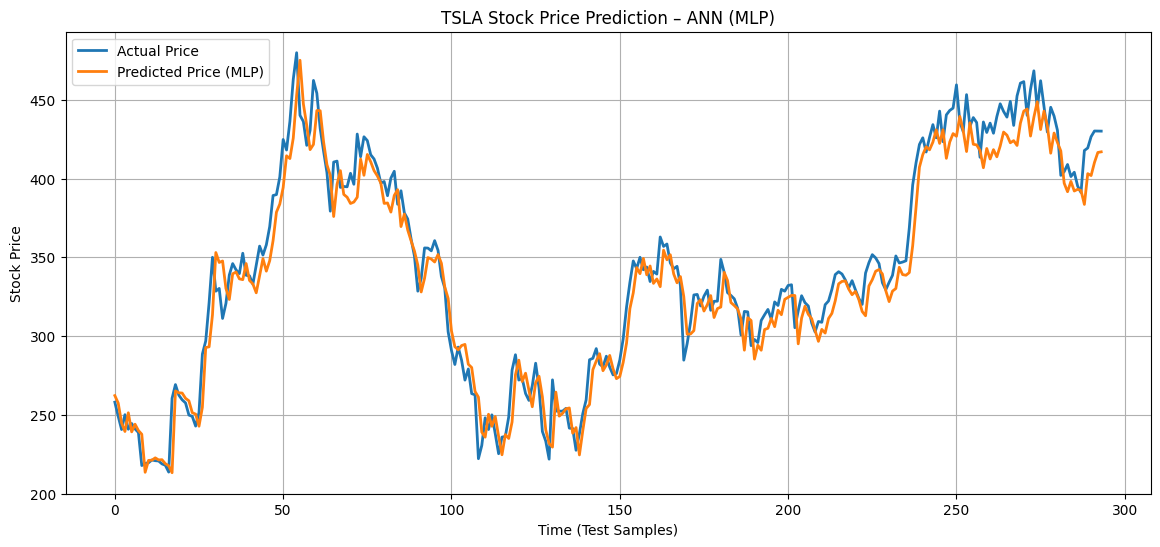

In [33]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual Price", linewidth=2)
plt.plot(pred_mlp, label="Predicted Price (MLP)", linewidth=2)
plt.title("TSLA Stock Price Prediction – ANN (MLP)")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

## 8. LSTM for Time-Series Forecasting


In [34]:
from sklearn.preprocessing import MinMaxScaler

close_prices = df['Close'].values.reshape(-1, 1)

mm_scaler = MinMaxScaler()
close_scaled = mm_scaler.fit_transform(close_prices)

def create_sequences(data, seq_len=20):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(close_scaled, SEQ_LEN)

split_idx = int(len(X_seq) * 0.8)
X_train_seq = X_seq[:split_idx]
X_test_seq  = X_seq[split_idx:]
y_train_seq = y_seq[:split_idx]
y_test_seq  = y_seq[split_idx:]

X_train_seq_t = torch.tensor(X_train_seq, dtype=torch.float32)
X_test_seq_t  = torch.tensor(X_test_seq, dtype=torch.float32)
y_train_seq_t = torch.tensor(y_train_seq, dtype=torch.float32)
y_test_seq_t  = torch.tensor(y_test_seq, dtype=torch.float32)

train_seq_ds = TensorDataset(X_train_seq_t, y_train_seq_t)
test_seq_ds  = TensorDataset(X_test_seq_t, y_test_seq_t)

train_seq_loader = DataLoader(train_seq_ds, batch_size=64, shuffle=True)
test_seq_loader  = DataLoader(test_seq_ds, batch_size=64, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

lstm_model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

n_epochs = 100
for epoch in range(n_epochs):
    lstm_model.train()
    total_loss = 0
    for xb, yb in train_seq_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = lstm_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_seq_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"[LSTM] Epoch {epoch+1}/{n_epochs}, Train MSE: {avg_loss:.4f}")

# evaluation
lstm_model.eval()
with torch.no_grad():
    pred_lstm = lstm_model(X_test_seq_t.to(device)).cpu().numpy()


y_test_inv = mm_scaler.inverse_transform(y_test_seq)
pred_lstm_inv = mm_scaler.inverse_transform(pred_lstm)

mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
print(f"LSTM – MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}")




[LSTM] Epoch 5/100, Train MSE: 0.0029
[LSTM] Epoch 10/100, Train MSE: 0.0018
[LSTM] Epoch 15/100, Train MSE: 0.0013
[LSTM] Epoch 20/100, Train MSE: 0.0011
[LSTM] Epoch 25/100, Train MSE: 0.0010
[LSTM] Epoch 30/100, Train MSE: 0.0008
[LSTM] Epoch 35/100, Train MSE: 0.0007
[LSTM] Epoch 40/100, Train MSE: 0.0008
[LSTM] Epoch 45/100, Train MSE: 0.0007
[LSTM] Epoch 50/100, Train MSE: 0.0006
[LSTM] Epoch 55/100, Train MSE: 0.0006
[LSTM] Epoch 60/100, Train MSE: 0.0006
[LSTM] Epoch 65/100, Train MSE: 0.0006
[LSTM] Epoch 70/100, Train MSE: 0.0005
[LSTM] Epoch 75/100, Train MSE: 0.0007
[LSTM] Epoch 80/100, Train MSE: 0.0005
[LSTM] Epoch 85/100, Train MSE: 0.0005
[LSTM] Epoch 90/100, Train MSE: 0.0005
[LSTM] Epoch 95/100, Train MSE: 0.0004
[LSTM] Epoch 100/100, Train MSE: 0.0004
LSTM – MSE: 224.6783, MAE: 11.3035


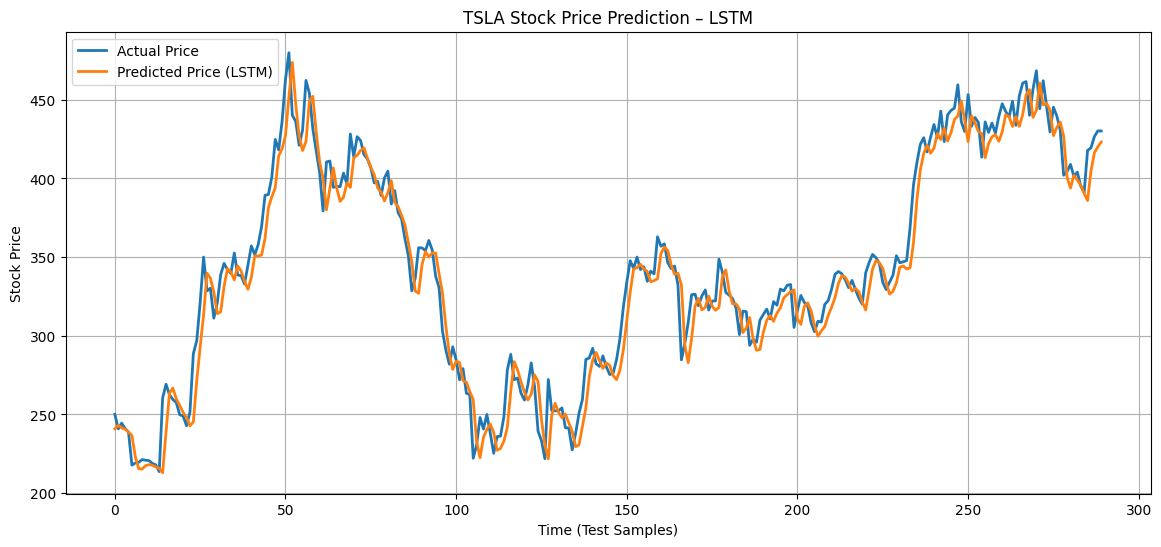

In [35]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label="Actual Price", linewidth=2)
plt.plot(pred_lstm_inv, label="Predicted Price (LSTM)", linewidth=2)
plt.title("TSLA Stock Price Prediction – LSTM")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

## 9. Comparison

In [39]:
import pandas as pd

# Create comparison table
results = {
    "Model": ["KNN", "Decision Tree", "Random Forest", "MLP", "LSTM"],
    "MSE": [1520.4441, 1404.5598, 1170.7715, 248.7090, 224.6783],
    "MAE": [29.3737, 27.2048, 24.7627, 12.1681, 11.3035]
}

df_results = pd.DataFrame(results)

# Display table
print(df_results)

# Save as CSV if needed
df_results.to_csv("TSLA_model_comparison.csv", index=False)


           Model        MSE      MAE
0            KNN  1520.4441  29.3737
1  Decision Tree  1404.5598  27.2048
2  Random Forest  1170.7715  24.7627
3            MLP   248.7090  12.1681
4           LSTM   224.6783  11.3035


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true1 = y_test 
y_true2=y_test_inv
preds_dict1 = {
    "KNN": pred_knn,
    "Decision Tree": pred_tree,
    "Random Forest": pred_rf,
        "MLP": pred_mlp
}
preds_dict2 = {
    "LSTM": pred_lstm_inv
}
results = []

for name, y_pred in preds_dict1.items():
    mse = mean_squared_error(y_true1, y_pred)
    mae = mean_absolute_error(y_true1, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true1, y_pred) 

    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2 (accuracy)": r2
    })
for name, y_pred in preds_dict2.items():
    mse = mean_squared_error(y_true2, y_pred)
    mae = mean_absolute_error(y_true2, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true2, y_pred) 

    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2 (accuracy)": r2
    })

results_df = pd.DataFrame(results)

results_df = results_df.round(4)

print(results_df)


           Model        MSE     RMSE      MAE  R2 (accuracy)
0            KNN  1520.4441  38.9929  29.3737         0.6800
1  Decision Tree  1404.5598  37.4775  27.2048         0.7044
2  Random Forest  1170.7715  34.2165  24.7627         0.7536
3            MLP   248.7090  15.7705  12.1681         0.9477
4           LSTM   224.6783  14.9893  11.3035         0.9522


In [48]:
import pandas as pd

models = ["KNN", "Decision Tree", "Random Forest", "MLP", "LSTM"]
mse = [1520.4441, 1404.5598, 1170.7715, 248.7090, 224.6783]
rmse = [38.9929, 37.4775, 34.2165, 15.7705, 14.9893]
mae = [29.3737, 27.2048, 24.7627, 12.1681, 11.3035]
r2  = [0.6800, 0.7044, 0.7536, 0.9477, 0.9522]

df = pd.DataFrame({
    "Model": models,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2
})

df


,Model,MSE,RMSE,MAE,R2
0,KNN,1520.4441,38.9929,29.3737,0.6800
1,Decision Tree,1404.5598,37.4775,27.2048,0.7044
2,Random Forest,1170.7715,34.2165,24.7627,0.7536
3,MLP,248.7090,15.7705,12.1681,0.9477
4,LSTM,224.6783,14.9893,11.3035,0.9522


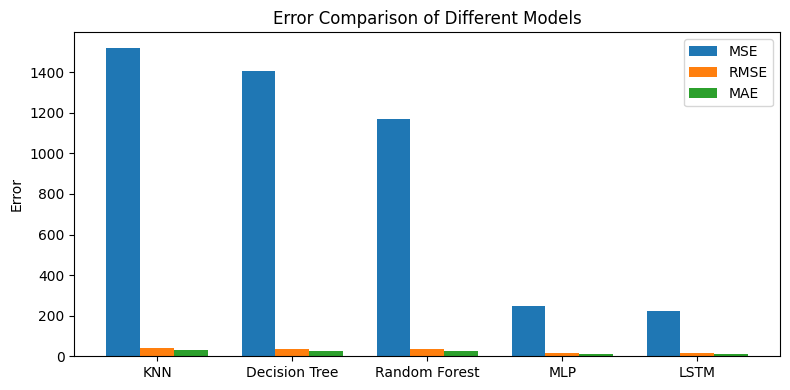

In [49]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(models))
width = 0.25 

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x - width, mse, width, label="MSE")
ax.bar(x,         rmse, width, label="RMSE")
ax.bar(x + width, mae, width, label="MAE")

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Error")
ax.set_title("Error Comparison of Different Models")
ax.legend()

plt.tight_layout()
plt.show()


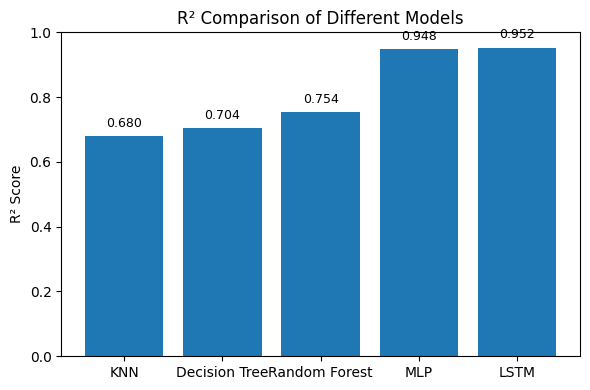

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(models, r2)
ax.set_ylim(0, 1.0)
ax.set_ylabel("R² Score")
ax.set_title("R² Comparison of Different Models")

for i, v in enumerate(r2):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [52]:
fig.savefig("C:\\Users\\Zhishan Yuan\\Downloads\\tsla_model_comparison_r2.png", dpi=300, bbox_inches="tight")


## 10. Summary
## Project Summary: TSLA Stock Price Prediction

### 1. Objective
The goal of this project is to forecast Tesla (TSLA) closing prices using a variety of machine learning models and to compare their predictive performance. Both traditional machine learning models and neural network models are evaluated on the same dataset and train–test split.

### 2. Models Evaluated
The following five models were implemented:

- **K-Nearest Neighbors (KNN)**
- **Decision Tree Regressor**
- **Random Forest Regressor**
- **Multi-Layer Perceptron (MLP) Regressor**
- **Long Short-Term Memory (LSTM) Network**

All models were trained to predict the next-day stock price based on historical features.

### 3. Evaluation Metrics
Model performance was evaluated using four regression metrics:

- **MSE (Mean Squared Error)** – average squared difference between predicted and true prices.
- **RMSE (Root Mean Squared Error)** – square root of MSE, in the same unit as the stock price.
- **MAE (Mean Absolute Error)** – average absolute prediction error.
- **R² Score (coefficient of determination)** – measures how much variance in the target can be explained by the model.  
  - R² close to 1 indicates very good fit;  
  - R² near 0 means the model does not explain the variance well.

The final results are:

| Model          | MSE      | RMSE    | MAE     | R² Score |
|---------------|----------|---------|---------|----------|
| KNN           | 1520.44  | 38.99   | 29.37   | 0.6800   |
| Decision Tree | 1404.56  | 37.48   | 27.20   | 0.7044   |
| Random Forest | 1170.77  | 34.22   | 24.76   | 0.7536   |
| MLP           | 248.71   | 15.77   | 12.17   | 0.9477   |
| LSTM          | 224.68   | 14.99   | 11.30   | 0.9522   |

### 4. Key Findings

1. **Neural network models clearly outperform traditional models.**  
   - Both **MLP** and **LSTM** achieve R² scores above 0.94, while KNN, Decision Tree, and Random Forest stay in the 0.68–0.75 range.
   - Their MSE, RMSE, and MAE are much lower, meaning the predicted prices are much closer to the true values.

2. **LSTM is the best-performing model overall.**  
   - LSTM obtains the **lowest MSE (224.68)** and **lowest MAE (11.30)**, as well as the highest **R² (0.9522)**, indicating that it captures temporal patterns in the TSLA time series more effectively than the other models.

3. **Random Forest is the strongest among traditional methods.**  
   - Compared with KNN and Decision Tree, Random Forest achieves lower error and higher R², showing the benefit of ensemble learning on tabular time-series features.

### 5. Conclusion
Overall, the experiments show that deep learning models, especially LSTM, are well-suited for TSLA stock price prediction when historical sequences are used as input. Traditional models provide reasonable baselines but fail to match the accuracy of neural networks.
